# Prerequisite
- preprocessed IMDB dataset
    - IMDB dataset oroginal: http://ai.stanford.edu/~amaas/data/sentiment/
    - IMBD dataset csv: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- glove pretrained model: https://nlp.stanford.edu/projects/glove/

# 1. load data

In [4]:
import matplotlib.pyplot as plt
from torchtext import data
from torchtext.data import TabularDataset
import torchtext.vocab as vocab
import torch.nn as nn
import torch
import logging
import time
import gc 

In [5]:
PATH = '/home/henry/devdir'

TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=3014)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   batch_first=False,
                   preprocessing = lambda x: int(x),
                   is_target=True)

# train_data, validation_data = TabularDataset.splits(
#     path='.', 
#     train='./Data/IMDB_clean_train.json', 
#     test='./Data/IMDB_clean_validation.json', 
#     format='json',
#     fields={'review': ('text', TEXT),
#             'sentiment': ('label', LABEL)}, skip_header=True)

dataset = TabularDataset(
                path=PATH + '/Research_mine_codes/Data/IMDB_clean_data_with_eos.json',
                skip_header=True,
                format='json',
                fields={'review': ('text', TEXT),
                        'sentiment': ('label', LABEL)})

# dataset = TabularDataset(
#                 path=PATH + '/mine_codes/Data/IMDB_clean_sentence.json',
#                 skip_header=True,
#                 format='json',
#                 fields={'review': ('text', TEXT),
#                         'sentiment': ('label', LABEL)})


FILE = PATH + '/data/glove.840B.300d.txt'
TEXT.build_vocab(dataset, vectors=vocab.Vectors(name=FILE,), min_freq=20)

/home/henry/anaconda3/envs/torch37/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/henry/anaconda3/envs/torch37/lib/python3.7/site-packages/torchtext/data/example.py:13: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


- test code

In [6]:
bs=3
data_iter= data.BucketIterator(dataset,
                    batch_size=bs,
                    device=-1, sort_key=lambda x: len(x.text), sort=False, 
                    shuffle=True, repeat=False)

/home/henry/anaconda3/envs/torch37/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [7]:
# test
b = next(iter(data_iter))
b.text.shape, b.label.shape

/home/henry/anaconda3/envs/torch37/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


(torch.Size([3, 3014]), torch.Size([3]))

In [8]:
b.label

tensor([1, 1, 1])

In [9]:
b.text

tensor([[    3,    14,  1443,  ...,     1,     1,     1],
        [    3,   613,  4288,  ...,     1,     1,     1],
        [    3,    44, 11501,  ...,     1,     1,     1]])

- special token

In [11]:
TEXT.vocab.stoi['<unk>'], TEXT.vocab.stoi['<pad>']

(0, 1)

# 2. Logger

In [27]:
def get_logger(name):
    
    # init
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter\
        ('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    formatter = logging.Formatter(
        fmt='%(asctime)s.%(msecs)03d %(levelname)s:\t%(message)s', datefmt='%Y-%m-%d %H:%M:%S'
    )
    
#     # handler: console
#     console = logging.StreamHandler()
#     console.setLevel(logging.INFO)
#     console.setFormatter(formatter)

    # handler: file
    timestr = time.strftime('%Y%m%d_%H:%M:%S')
    file_name = 'log/{}_{}.log'.format(name, timestr)

    file_handler = logging.FileHandler(file_name)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    # wrap
    logger.handlers.clear()
#     logger.addHandler(console)
    logger.addHandler(file_handler)
    return logger

# 3. scheduler simulation

In [14]:
class TestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lm = nn.Linear(2,3)
    def forward(self, x):
        return self.lm(x)

test_model = TestModel()

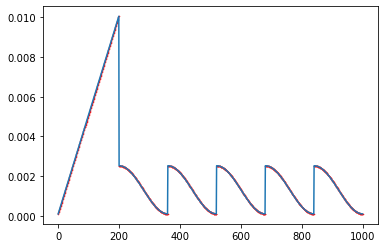

In [16]:
warmup_epoch = 1
total_epoch = 5
n_iter = 200 
n_annealing_iter = (total_epoch-warmup_epoch)*n_iter
n_cycle = 5

max_lr = 0.01; min_lr = 0.0001;
base_lr = max_lr / (warmup_epoch*n_iter)
bias = min_lr * (1/base_lr)

####################### scheduler1
lr_ls = []
optimizer = torch.optim.Adam(test_model.parameters(), lr=base_lr)

lambda1 = lambda x: bias+x
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

j=0
for e in range(total_epoch):
    if e == warmup_epoch:
        optimizer = torch.optim.Adam(test_model.parameters(), lr=optimizer.param_groups[0]['lr']/4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(n_annealing_iter/n_cycle), T_mult=1, eta_min=min_lr)
    for _ in range(n_iter):
        j+=1
        lr_ls.append(scheduler.get_last_lr()[0])
        optimizer.step()
        scheduler.step()
        
plt.plot(lr_ls)
plt.scatter(range(len(lr_ls)), lr_ls, s=0.3, c='r')

# 4. Model

In [29]:
class net(nn.Module):
    def __init__(self, voc_size, hidn_size, emb_size=300):
        super().__init__()
        self.pos_id = TEXT.vocab.stoi['positive']
        self.neg_id = TEXT.vocab.stoi['negative']

        self.voc_size = voc_size
        self.emb_size = emb_size
        self.hidn_size = hidn_size
        self.emb = nn.Embedding(num_embeddings=voc_size, embedding_dim=emb_size) # in: (bs, seq_len); out: (bs, seq_len, emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidn_size, bidirectional=True, dropout=0.2, batch_first=True) # in: (bs, seq, dim); hidn in: (num_layers * num_directions, batch, hidden_size)
        self.lm_out = nn.Linear(hidn_size*2+emb_size, voc_size) # input concatenated_out: (seq_len, bs, hidn_dim) -> permute: (bs, seq_len, hidn_dim) 

    def init_state(self, bs):
        return (torch.zeros(size=(2, bs, self.hidn_size)), torch.zeros(size=(2, bs, self.hidn_size)))
        
    def forward(self, x, prev_state, label):
        state_h, state_c = prev_state
        bs = len(x)

        # processing label part
        label[label==1] = self.pos_id # label: (1, bs)
        label[label==0] = self.neg_id
        
        label_emb = self.emb(label.view(1, -1)) # shape: (seq_len=1, bs, emb_size)
        label_emb = label_emb.expand(x.size()[1]-2, bs, self.emb_size) # shape: (seq_len-2, bs, emb_size)
        label_emb = label_emb.permute(1, 0, -1)
        
        # processing hidden state part
        emb = self.emb(x) # shape: (bs, seq_len, emb_size)
        out, (state_h, state_c) = self.lstm(emb, (state_h[:,:bs,:].contiguous(), state_c[:,:bs,:].contiguous()))
        
        forward_out = out[:, :, :self.hidn_size] # shape: (bs, seq, hidn_dim)
        backward_out = out[:, :, self.hidn_size:]
        concat_h = torch.cat([forward_out[:,:-2,:], backward_out[:,2:,:]], dim=2) # shape: (bs, seq_len-2, hidn*num_dir)
        
        # concat label & concatenated hidn state
        final_in = torch.cat([concat_h, label_emb], dim=2) # shape: (bs, seq_len-2, hidn_dim*2+emb+size)
        final_out = self.lm_out(final_in)  # shape: (bs, seq_len-2, voc_size)

        return final_out, (state_h, state_c)


def init_weight(m):
    for name, param in m.named_parameters():
        if 'emb' == name:
            continue
        if 'weight' in name:
            nn.init.xavier_normal_(param.data)
        if 'bias' in name:
            nn.init.constant_(param.data, 0)

def save_model(model, f='0930_biLSTM_50epoch_label_cosine_annealing.model'):
    fn = 'source/{}.pkl'.format(f)
    torch.save(model.state_dict(), fn)

def repackage_hidden(h):
    if type(h) == torch.Tensor:
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

# 5. Train

In [30]:
import pickle

fn = 'source/1001_sample_pos_sentences.pkl'
with open(fn, 'rb') as f:
    length_pos_sample_dict = pickle.load(f)

fn = 'source/1001_sample_neg_sentences.pkl'
with open(fn, 'rb') as f:
    length_neg_sample_dict = pickle.load(f)

def init_weight(m):
    for name, param in m.named_parameters():
        try:
            if 'emb' == name:
                continue
            if 'weight' in name:
                nn.init.xavier_normal_(param.data)
            if 'bias' in name:
                nn.init.constant_(param.data, 0)
        except:
            continue
            
def reverse_token(tensor_):
    return ' '.join([TEXT.vocab.itos[i] for i in tensor_])

def check_pos_neg(model, logger):
    """
    pos, neg label에 따라 token의 분포가 다른지 확인
    """

    def return_pred_review(model, data_, label_, is_label=True):
        """
        return logit for each sequence
        - out: shape (bs*seq_len, voc_len)
        """
        device = 'cuda'
        bs = len(label_)
        model.eval()

        with torch.no_grad():
            data_ = data_.to(device)
            prev_state = model.init_state(bs=bs)
            prev_state = list(map(lambda x: x.to(device), prev_state))
            if is_label:
                label_ = label_.to(device)
                out, prev_state = model(data_, prev_state, label_)
            else:
                out, prev_state = model(data_, prev_state)
        return out

    def _make_batch_data(ls_value):
        """
        batch_iterator에 사용되는 함수
        10 quntile 글자 단위로 묶여 있는 배치 return
        """
        source = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(ls) for ls in ls_value], batch_first=True)
        return source

    def batch_iterator(full_dict, is_pos=True):
        """
        dict사용하여 batch data 생성하는 iterator
        """
        for k, v in full_dict.items():
            source = _make_batch_data(v)
            if is_pos:
                labels = torch.ones(len(source), dtype=torch.long)
            else:
                labels = torch.zeros(len(source), dtype=torch.long)
            yield source, labels
    
    generated_label = []
    for batch, label in batch_iterator(length_pos_sample_dict, is_pos=True):
        out = return_pred_review(model, batch, label, is_label=True)
        generated_label.append(out)
        
    generated_ls_neg = []
    for batch, label in batch_iterator(length_pos_sample_dict, is_pos=False):
        out = return_pred_review(model, batch, label)
        generated_ls_neg.append(out)
        
    for i in range(10):
        logger.info('pos == neg?: {}'.format(torch.all(generated_label[i] == generated_ls_neg[i])))


def train(model, data_iter, device, logger, warmup_epoch, total_epoch, n_cycle, max_lr=0.01, min_lr=0.0001, j=0, f='tag', q=0.8):
    """
    parameters
    ----------
    epoch: epoch for train lr
    j: epoch for log
    """
    model.to(device)
    loss_func = nn.CrossEntropyLoss()
    
    ####################### scheduler
    n_iter = len(data_iter) # annealing starting point: 200/1000
    n_annealing_iter = (total_epoch-warmup_epoch)*n_iter
    base_lr = max_lr / (warmup_epoch*n_iter)
    bias = min_lr * (1/base_lr)
    lambda1 = lambda x: bias+x
    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    for e in range(total_epoch):
        if e == warmup_epoch:
            optimizer = torch.optim.SGD(model.parameters(), lr=optimizer.param_groups[0]['lr'])
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(n_annealing_iter/n_cycle), T_mult=1, eta_min=min_lr)
        j +=1
        total_loss = 0

        for i, batch in enumerate(data_iter, 1):
            model.train()
            batch_x, label = map(lambda x: x.to(device), [batch.text, batch.label])
            batch_y = batch_x[:, 1:-1].to(device)
            del batch
            
            prev_state = model.init_state(bs=len(batch_x))
            prev_state = repackage_hidden(prev_state)
            prev_state = list(map(lambda x: x.to(device), prev_state))
            out, prev_state = model(batch_x, prev_state, label)

            ###################################################### sample
            x, y = torch.where(batch_y > 1) # special token id: 0,1,2,3
            target_token_len = len(x)
            sample_n = int(target_token_len*q)

            # sample token idx
            token_idx = torch.randperm(target_token_len)[:sample_n]

            # select target tokens from target
            batch_y = batch_y[x[token_idx], y[token_idx]]
            out = out[x[token_idx], y[token_idx], :]
            ###################################################### sample
            optimizer.zero_grad()
            loss = loss_func(out, batch_y)
            # loss = loss/len(batch_y_)
            total_loss += loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            scheduler.step()

            if i%10 == 0:
                logger.info(total_loss/i)
                logger.info('epoch: {}'.format(j))
                logger.info('lr: {}'.format(scheduler.get_last_lr()[0]))
                logger.info('x')
                logger.info(reverse_token(torch.argmax(out, dim=1).detach()))
                gc.collect()        
        # save model for each epoch
        save_model(model, f= f + '_' + str(j) +'.model')
        
        logger.info(total_loss/i)
        logger.info('epoch: {}'.format(j))
        logger.info('x')
        logger.info(reverse_token(torch.argmax(out, dim=1).detach()))
        logger.info('y')
        logger.info(reverse_token(batch_y))
        check_pos_neg(model, logger)

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
f = 'test'
logger = get_logger(f)

## label model
model = net(voc_size=len(TEXT.vocab), emb_size=300, hidn_size=50)
model.apply(init_weight)

# load weight
# fn = './source/' + '1005_label_model_review_15.model.pkl'
# model.load_state_dict(torch.load(fn, map_location=device))

model.emb.weight.data.copy_(TEXT.vocab.vectors)
model.emb.weight.requires_grad = False
train(model, data_iter, device, logger, warmup_epoch=1, total_epoch=50, n_cycle=5, max_lr=0.5, min_lr=0.0008, j=0, f=f)